### Before running this program. Make sure you have "Image.png", "trimmed_lab1.mp4" files in your directory. They are available at https://github.com/Neuroosapiens/Neuroosapiens

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
from keras.models import model_from_json
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


Using TensorFlow backend.


# 1st problem

In [4]:
raw_img = cv2.imread("project-1.png")
raw_img = cv2.resize(raw_img, (672, 376), interpolation = cv2.INTER_AREA)

invGamma = 1.0 / 1.0

table = np.array([((i / 255.0) ** invGamma) * 255
                    for i in np.arange(0, 256)]).astype("uint8")
raw_img_mod = cv2.LUT(raw_img, table)
i = 0

C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


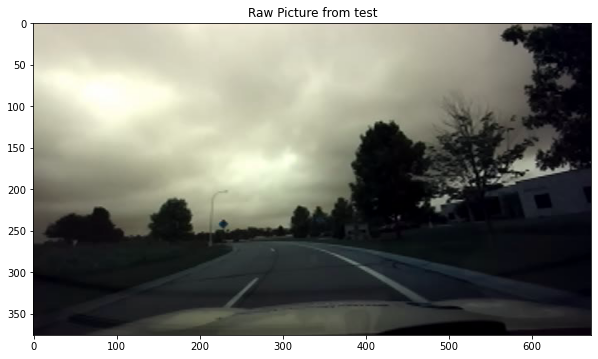

In [5]:
# matlab plot follow RGB format, cv2 follows BGR format for reading images.
fig = plt.figure(figsize=(10,10))
plt.imshow(raw_img_mod)

plt.title("Raw Picture from test") 
fig.show()

In [6]:
converted_rawimg = (cv2.cvtColor(raw_img_mod, cv2.COLOR_BGR2RGB))   
###
gray_scale_rawimg = (cv2.cvtColor(raw_img_mod, cv2.COLOR_BGR2GRAY))
#a = (cv2.cvtColor(gray_scale_rawimg, cv2.COLOR_BGR2GRAY))


Text(0.5, 1.0, 'Gray Scale Picture')

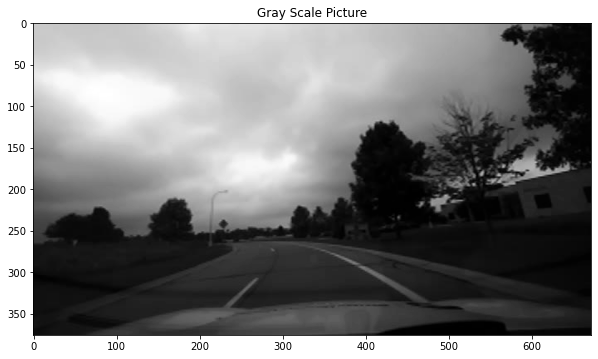

In [7]:
fig1 = plt.figure(figsize=(10,10))
#ax = plt.subplot(2,2,1)
plt.imshow(gray_scale_rawimg, cmap='gray')

#calculate histogram for converted image plot
# ax = plt.subplot(2,2,2)
# for i, col in enumerate(['r','g','b']):
#     hist = cv2.calcHist([converted_rawimg],[i],None,[256],[0,256])
#     ax.plot(hist, color = col)
    
plt.title("Gray Scale Picture") 
#fig1.show()

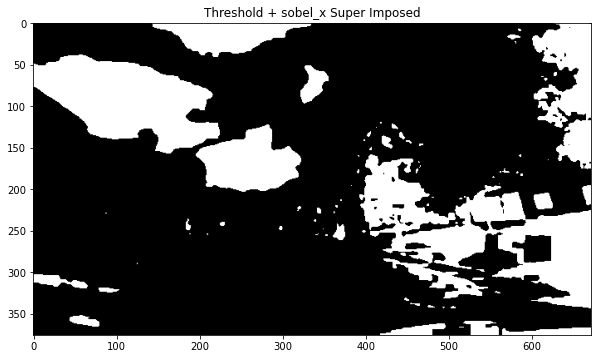

In [8]:
# Processing for yellow line detection
# create HSL color space
#fig3 = plt.figure(figsize=(18,18))

width = raw_img.shape[1]
height = raw_img.shape[0]

#print(height)

hls_img = cv2.cvtColor(converted_rawimg, cv2.COLOR_RGB2HLS)

s_channel = hls_img[:,:,2] 

blur = cv2.GaussianBlur(s_channel,(5,5),0)

lower = np.uint8([ 70])
upper = np.uint8([ 255])
mask = cv2.inRange(blur, lower, upper)
b = cv2.bitwise_or(blur, mask, mask = mask)
#s_mask = cv2.inRange(s_channel, light_orange, dark_orange)


fig3 = plt.figure(figsize=(10,10))
plt.title("Threshold + sobel_x Super Imposed") 
plt.imshow(b, cmap='gray')
#cv2.imshow("res",s_channel)
#cv2.waitKey(0)
#plt.text(100, 100,"Lane Detection using Canny Edge Filter",size=22,color="white",fontweight="bold" )
#fig3.show()

In [9]:
def pre_process_img(frame, width, height):
    
    invGamma = 1.0 / 1.0

    table = np.array([((i / 255.0) ** invGamma) * 255
                    for i in np.arange(0, 256)]).astype("uint8")
    raw_img_mod = cv2.LUT(frame, table)
    
    #convert to gray scale
    gray_scale_rawimg = (cv2.cvtColor(raw_img_mod, cv2.COLOR_BGR2GRAY))
    
    convert_hls = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
    
    s_channel = convert_hls[:,:,2] 
    
    blur = cv2.GaussianBlur(gray_scale_rawimg,(5,5),0)
    
    ret,thresh1 = cv2.threshold(blur,67,255,cv2.THRESH_BINARY) #use this for 
    #before 67, 255 for carla  change it to 170
    
    # Gradient x is calculated:
    # the depth of the output is set to CV_16S to avoid overflow
    # CV_16S = one channel of 2-byte signed integers (16-bit signed integers)
    gradient_x = cv2.Sobel(blur, cv2.CV_16S, 1, 0, 3)

    # Gradient y is calculated:
    # the depth of the output is set to CV_16S to avoid overflow
    # CV_16S = one channel of 2-byte signed integers (16-bit signed integers)
    gradient_y = cv2.Sobel(thresh1, cv2.CV_16S, 0, 1, 3)

    # Conversion to an unsigned 8-bit type:
    sobel_x = cv2.convertScaleAbs(gradient_x)
    
    abs_gradient_y = cv2.convertScaleAbs(gradient_y)
    
    # sobel_magnitude
    s_mag = np.sqrt(gradient_x + gradient_y)

    return blur, sobel_x, s_channel, thresh1,  gray_scale_rawimg


C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 1.0, 'Super Imposed')

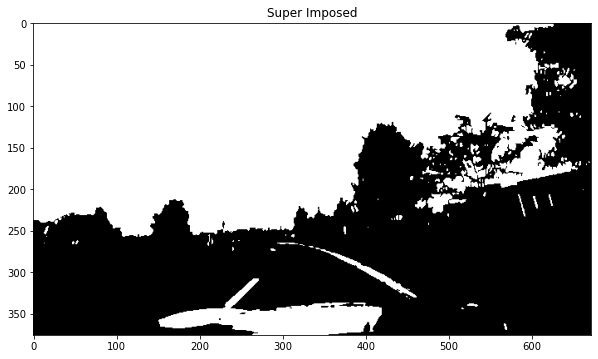

In [11]:
blur, sobel_x, s_channel, thresh1, gray_scale_rawimg = pre_process_img(raw_img, width, height)
fig = plt.figure(figsize=(10,10))
super_imposed = cv2.addWeighted(thresh1, 1, sobel_x, 1, 0)
#image binarization
th, im_th_tz = cv2.threshold(super_imposed, 50, 255, cv2.THRESH_BINARY) #changd it to 50 from 12
plt.imshow(im_th_tz, cmap='gray')
plt.title("Super Imposed") 
#cv2.imshow("ret", thresh1)
#cv2.waitKey(0)

In [12]:
#create region of interest (ROI). Since we only need small portion of carera to detect lines approximately 2/3 of camera image size
def masking(frame):
    # only 2/3rd of an image is enough
    
    # Creates a trapeizoid polygon for the mask defined by four (x, y) calculated manually from image
    # for carla use this
    ROI_points = np.float32([[(0, 340), (width , 340),(400,270), (200, 270)]])
    # for lab test vehcile use this
    #ROI_points = np.float32([[(100, 340), (600, 340),(380,270), (280, 270)]]) #--latest
    #ROI_points = np.float32([[(50, 350), (672, 350),(672, 250), (0, 250)]])
    #print(dup_ROI_points)
    mask = np.zeros_like(frame)
    cv2.fillPoly(mask, np.int32(ROI_points), 255)
    # Bitwise operation between canny image and mask image
    masked_image = cv2.bitwise_and(frame, mask)

    return masked_image, ROI_points, mask


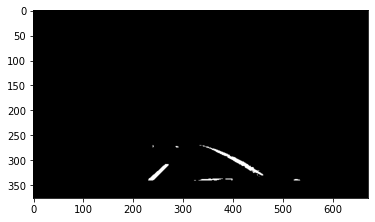

In [13]:
ROI, ROI_points, mask = masking(im_th_tz)
plt.imshow( ROI, cmap='gray')
#plt.imshow(bmask, cmap='gray')
#cv2.imshow("ROI", ROI)
#cv2.waitKey(0)

In [14]:
#desired ROI Points

def birds_eye_perspective(frame, ROI_points, width, height):

    padding = int(0.10 * width) # change this to o.25 to 0.20 for carla

    desired_ROI_points = np.float32([(padding ,height), (width-padding, height), (width-padding,0), (padding, 0)])  
    #desired_ROI_points = np.float32([(200,700), (1200,700), (1200,0), (200,0)])  

    # transformation matrix is generated. Which is responsible for birds eye
    warp_matrix = cv2.getPerspectiveTransform(ROI_points, desired_ROI_points)

    # we need inverse transformation matrix to rollback the final processed lane detected image onto the orginal raw image
    inverse_warpmatrix = np.linalg.inv(warp_matrix)
    
    warp_res = cv2.warpPerspective(frame, warp_matrix, (width,height),cv2.INTER_LINEAR)
    
    #smoothen the lane lines after warping
    
    smoothedLine = np.empty(shape=[height,width])
    
#     for i in range (0,height-1):
#         for j in range(0,width-1):
#             smoothedLine[i,j] =  4 * warp_res[i,j] -[warp_res[i-1,j] + warp_res[i+1, j] + warp_res[i, j-1] + warp_res[i,j+1]]
    
    return warp_res, inverse_warpmatrix, smoothedLine
    
#cv2.imshow("result",persResult)
#cv2.waitKey(0)
#plt.imshow(persResult)

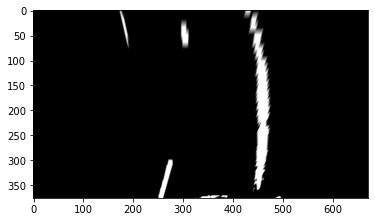

In [15]:
warp_res, inverse_warpmatrix, smoothedLine = birds_eye_perspective(ROI, ROI_points, width, height)


plt.imshow(warp_res, cmap='gray')
#plt.title("BirdsImage at ROI")
#cv2.imshow("smooth",warp_res)
#cv2.waitKey(0)

frame_counter = 0

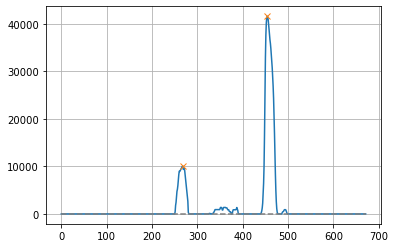

[268 454]


In [16]:
from scipy.signal import find_peaks

x = np.sum(warp_res[warp_res.shape[0] // 2:, :], axis=0)

#warp_res.shape[0] // 2


peaks, _ = find_peaks(x, height = 120, distance = 120)
# change it from 100 to 120
plt.plot(x)

plt.plot(peaks, x[peaks], "x")

plt.plot(np.zeros_like(x), "--", color="gray")


plt.grid()

plt.show()

#print(peaks)

print(peaks)
# plt.plot(histogram)


# # get mid point of histogram
# midpoint = np.int(histogram.shape[0] // 2)

# #get first highest peak from left of the midpoint
# left_point1 = np.argmax(histogram[:midpoint]) 

# print(left_point1)

# #get second highest right peak
# right_point2 = np.argmax(histogram[midpoint:]) + midpoint

# print(right_point2)

# # get highest peak between  first highest peak and second highest peak

# #betw_lp1_rp2 = np.argmax(histogram[:])

# print((histogram))

# print((histogram[150:429]))

# print(np.argmax(histogram[150:429]))


In [17]:
def sliding_windows(frame, width, height, frame_counter):
    
    if frame_counter == 0:
        global leftx_old
        leftx_old = None
    
    
    
    histogram = np.sum(frame[frame.shape[0] // 2:, :], axis=0) # change this to np.sum(:, :), axis = 0) for carla
    
    kernel_size = 25
    
    kernel = np.ones(kernel_size) / kernel_size
    
    ravg_histogram = np.convolve(histogram, kernel, mode='same')
    

    peaks, _ = find_peaks(ravg_histogram, height = 100, distance = 90)
    # change to ravg histogram for file which does not belong to carla for carla distance = 120
    
    old_frame = frame.copy()
    
    sliding_res = old_frame
    
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print(peaks)

    
    nwindows = 12
    
    margin = int((1 / 14) * width) #chnaged from 18
    
    minpix = 10
    
#     print(peaks)
    
#     leftx_base = peaks[1]
    
    
#     rightx_base = peaks[2] 
    #print(leftx_base)
    #print(rightx_base)
    
    window_height = np.int(height // nwindows)

    nonzero = sliding_res.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # overhead loop 
   
    
    leftx_current = leftx_base # current here indicates previous value base here indicated current value


    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []
    
    pl_lefty = []
    pl_leftx = []
    pl_righty = []
    pl_rightx = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height- (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(sliding_res, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (255, 255, 255), 4)
        cv2.rectangle(sliding_res, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (255, 255, 255), 4)

        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (
                           nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (
                            nonzerox < win_xright_high)).nonzero()[0]
        
        pl_lefty = np.append(pl_lefty, nonzeroy[good_left_inds])
        pl_leftx = np.append(pl_leftx, nonzerox[good_left_inds])
        pl_righty = np.append(pl_righty, nonzeroy[good_right_inds])
        pl_rightx = np.append(pl_rightx, nonzerox[good_right_inds])
    
        #pixels_loc_left = np.concatenate(pixels_loc_lefty)
#         print(pixels_loc_lefty.shape)
#         print(pixels_loc_lefty)
#         print("from here")
#         print(pixels_loc_leftx)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
    

        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right lane pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
#     plt.plot(histogram)
#     plt.plot(ravg_histogram)
        
    # copy previous pixel frame to next frame for the left line
    
#     if frame_counter > 0:
#         for i in range (nonzeroy.length()):
    # prints non zero pixels location within the peak 1 range.
#     print(pixels_loc_lefty)
#     print(pixels_loc_leftx)
#     print(pixels_loc_lefty.shape)
#     print(pixels_loc_leftx.shape)

    #leftx_old = leftx_current
    # store the pixels_loc_lefty and x value to csv file
    pl_left_df = pd.DataFrame({"x" : pl_leftx.ravel(), "y":pl_lefty.ravel()})
    pl_right_df = pd.DataFrame({"x" : pl_rightx.ravel(), "y":pl_righty.ravel()})
    return sliding_res, leftx, lefty, rightx, righty, peaks, leftx_current, ravg_histogram, pl_left_df, pl_right_df
   



C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link 

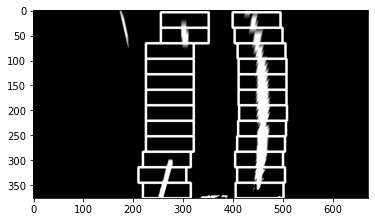

In [18]:
sliding_res, leftx, lefty, rightx, righty, histogram, leftx_current, histogram, pl_left_df, pl_right_df = sliding_windows(warp_res, width, height, frame_counter)
#plt.plot(histogram)
#plt.xlim(180,250)
plt.imshow(sliding_res, cmap='gray')
#cv2.waitKey(0)

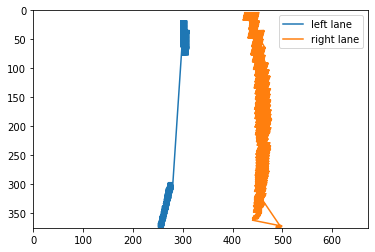

In [39]:
plt.plot(pl_left_df.iloc[:,0], pl_left_df.iloc[:,1], label="left lane")
plt.plot(pl_right_df.iloc[:,0], pl_right_df.iloc[:,1], label ="right lane")
plt.xlim(0, width)
plt.ylim(height, 0)
plt.legend(loc="upper right")

In [70]:
#Store pixels values for post processing

pl_right_df.to_csv(r'left_lane_ransac.csv')

In [16]:
def lane_fill(frame, leftx, lefty, rightx, righty, width, height, inverse_warpmatrix, leftx_current, frame_counter, pl_left_df, pl_right_df):
        
#     global left_fit_prev
#     global right_fit_prev
#     global left_line_avg
    global x
    global y
    global z
    print(frame_counter)
    
    if frame_counter == 0:
        x = np.zeros((10, 1), dtype=np.float64)
        y = np.zeros((10, 1), dtype=np.float64)
        z = np.zeros((10, 1), dtype=np.float64)
          
#     if leftx_current > 0:
        
#         # using 2nd order polynomical fit
#         left_fit = np.polyfit(lefty, leftx, 2)

#         right_fit = np.polyfit(righty, rightx, 2)
        
#         left_fit_prev = left_fit
#         right_fit_prev = right_fit
        
#     else:
#         left_fit = left_fit_prev
#         right_fit = right_fit_prev
        

        
#     x = np.append(x, left_fit[0])

#     y = np.append(x, left_fit[1])
    
#     z = np.append(x, left_fit[2])

    
    
#     left_fit_prev = [x[frame_counter - 11], y[frame_counter - 11], z[frame_counter - 11]]
    
#     # create a array for plotting the ransac model
#     ploty = np.linspace(376, 0, 200).reshape(-1,1)
#     #change to 100 for road
#     # Do Ransac Operation Here
    
#     rn_leftx = np.array(pl_left_df['x'])
#     rn_lefty = np.array(pl_left_df['y']).reshape(-1,1) 
#     rn_rightx = np.array(pl_right_df['x'])
#     rn_righty = np.array(pl_right_df['y']).reshape(-1,1) 
    
#     #create ransac model for left lane and right lane
#     model_left, ransac_left = make_pipeline(PolynomialFeatures(3), RANSACRegressor(min_samples = 20, max_trials = 80, loss='absolute_loss', residual_threshold=10))
#     ransac_left.fit(rn_lefty, rn_leftx)
    
#     model_right, ransac_right = make_pipeline(PolynomialFeatures(3), RANSACRegressor(min_samples = 20, max_trials = 80, loss='absolute_loss', residual_threshold=10))
#     ransac_right.fit(rn_righty , rn_rightx)
    
#     #Predict the model left lane and right lane
    
#     rn_left_predicty =  ransac_left.predict(ploty)
    
    
#     rn_right_predicty = ransac_right.predict(ploty)
    
    
#     rn_middle_predicty = (rn_left_predicty + rn_right_predicty) / 2
    

    #left_fit_prev = np.concatenate(left_fit_prev)

    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)

#     # we got the polynomial, now we need to plot that onto image by creating a number 
    ploty = np.linspace(370, 100, height-1)
    #calc left and right polynomials using ploty

    left_fitx = (left_fit[0] * ploty ** 2) + (left_fit[1] * ploty) + left_fit[2]

#     period = 10
    
#     left_line_avg = np.zeros((375,))

#     if frame_counter > period:
#         for p in range (period):
#             left_fitx_dup = (x[frame_counter - p] * ploty ** 2) + (y[frame_counter - p] * ploty) + z[frame_counter- p]
#             left_line_avg = np.add(left_line_avg, left_fitx_dup) 

            
#     left_line_avg = left_line_avg / period
    
    right_fitx = (right_fit[0] * ploty ** 2) + (right_fit[1] * ploty) + right_fit[2]
    
    
    lane_zeros = np.zeros_like(frame).astype(np.uint8)
    
    col_lane_lines = np.dstack((lane_zeros, lane_zeros, lane_zeros))
    
    fill_region = np.dstack((lane_zeros, lane_zeros, lane_zeros))
    
    
#     if frame_counter > period:
#         left = np.array([np.transpose(np.vstack([left_line_avg, ploty]))])
#     else:
    left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

    right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])

    points = np.hstack((left, right))

#debug prints
#     plt.scatter(rn_left_predicty, ploty)
#     plt.scatter(rn_right_predicty, ploty)
#     plt.ylim(350, 0)
#     plt.xlim(0, 672)

    #cv2.line(col_lane_lines, np.int_(points), (0,255,0), 4)
    
    #cv2.line(col_lane_lines, np.int_(points), (0,255,0), 4)
    
#     rn_middle_diff_y = []
    
#     #add the centre line to the frame
#     for i in range(0, ploty.shape[0]-1):
#         diff_y = rn_middle_predicty[i+1] - rn_middle_predicty[i]
#         rn_middle_diff_y.append(diff_y)
#         col_lane_lines = cv2.line(col_lane_lines, (np.int_(rn_middle_predicty[i]), (np.int_(ploty[i]))), (np.int_(rn_middle_predicty[i + 1]), (np.int_(ploty[i + 1]))), (255,0,0), 10)
    
#     print(np.mean(rn_middle_diff_y))
    
        
    #fill  the region between lane lines with green color
    fill_region = cv2.fillPoly(fill_region, np.int_(points), (0,255, 0))
    col_lane_lines = fill_region
    
    #col_lane_lines = cv2.addWeighted(col_lane_lines, 1, fill_region, 0.5, 0)
    
   
    # unwarp the image
    inverse_Result = cv2.warpPerspective(col_lane_lines, inverse_warpmatrix, (width,height),cv2.INTER_LINEAR)
    
    return inverse_Result, col_lane_lines, left, right, ploty, x, y, z

0


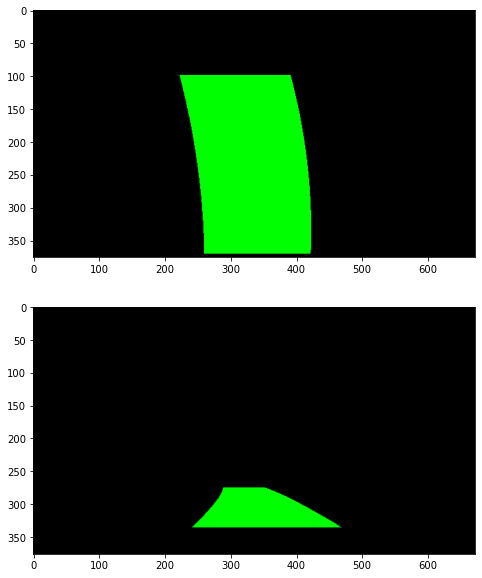

In [17]:
#cv2.imshow("Final Result", out_img)
#cv2.waitKey(0)
inverse_Result, col_lane_lines, left, right_fitx, ploty, x, y, z = lane_fill(sliding_res, leftx, lefty, rightx, righty, width, height, inverse_warpmatrix, leftx_current, frame_counter, pl_left_df, pl_right_df)

figure, (ax1, ax2) = plt.subplots(2,1)

figure.set_size_inches(10, 10)

ax1.imshow(col_lane_lines)
ax2.imshow(inverse_Result)



-1

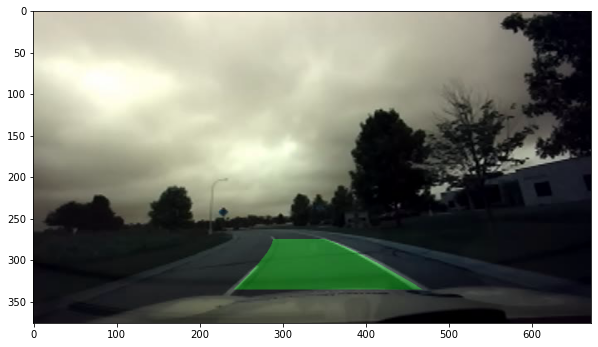

In [18]:
# overlay the unwarped image onto raw image

Final_result = cv2.addWeighted(raw_img, 1, inverse_Result, 0.3, 0)
fig = plt.figure(figsize=(10,10))
plt.imshow(Final_result)
cv2.imshow("Final Result",Final_result)
cv2.waitKey(0)

# Loading lan detection algorithm along with video


In [21]:

# open the video file
cap = cv2.VideoCapture("trimmed_lab1.mp4")


# Frame size
width = 672
height= 376

#calculate number of frames
fps = cap.get(cv2.CAP_PROP_FPS)

#Total no of frames in the video capture during our lab 1 test demo
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
duration = float(totalFrames) / float (fps)

print(totalFrames)

#frame_counter
frame_counter = -1

# save the post processed video to new file as name "output.avi"
out = cv2.VideoWriter('project_output_1.mp4',cv2.VideoWriter_fourcc('H','2','6','4'), 20, (width ,height))


#Read the video file
while(cap.isOpened()):
    ret, pre_frame = cap.read()
    frame_counter = frame_counter + 1
#Check if there are any frames in video
    if ret == True:
#do processing of frames
        frame = cv2.resize(pre_frame, (width, height), interpolation = cv2.INTER_AREA)
        blur, sobel_x, s_channel, thresh1 = pre_process_img(frame, width, height)
        super_imposed = cv2.addWeighted(thresh1, 1, sobel_x, 1, 0)
        #image binarization
        th, im_th_tz = cv2.threshold(super_imposed, 8, 255, cv2.THRESH_BINARY)
        ROI, ROI_points, mask = masking(im_th_tz)
        warp_res, inverse_warpmatrix, smoothedLine = birds_eye_perspective(ROI, ROI_points, width, height)
        sliding_res, leftx, lefty, rightx, righty, histogram, leftx_current, histogram, pl_left_df, pl_right_df = sliding_windows(warp_res, width, height, frame_counter)
        inverse_res, col_lane_lines, left_fitx, right_fitx, ploty, x, y, z = lane_fill(sliding_res, leftx, lefty, rightx, righty, width, height, inverse_warpmatrix, leftx_current, frame_counter, pl_left_df, pl_right_df)
        final_res = cv2.addWeighted(frame, 1, inverse_res, 0.3, 0)
#show the post processed video in new window
        cv2.putText(final_res, str(frame_counter), (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (100, 255, 0), 3, cv2.LINE_AA)
        cv2.imshow("Lane detection", final_res)
        
 
#save the post process frames to new video file
        out.write(final_res)
# to exit the window press "q" key
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
# else loop break
    else:
      break
    
# release the video capture object
cap.release()
out.release()
# destroy all windows
cv2.destroyAllWindows()

200.0


C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Lenovo P330\anaconda3\envs\Ml\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wis

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [507]:
print(sliding_res.nonzero())

(array([  0,   0,   0, ..., 375, 375, 375], dtype=int64), array([211, 212, 213, ..., 425, 426, 485], dtype=int64))


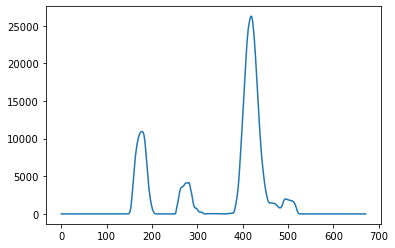

In [284]:
plt.plot(histogram)

In [88]:
x.shape

(5, 1)

In [107]:
x

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.05382001e-05])

In [108]:
x.shape

(11,)

In [ ]:
left_line_avge = np.zeros((375,1))




In [ ]:
print(left_line_avge.shape)